[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/fonnesbeck/instats_gp/blob/main/sessions/Session_2.ipynb)

# Session 2: Kernels, Likelihoods, and Model Building

## Learning Objectives

By the end of this session, you will:

- Understand different kernel families and their properties
- Learn kernel composition via addition and multiplication
- Understand marginal vs latent GP formulations
- Work with non-Gaussian likelihoods
- Build additive and multiplicative models for real-world data

This session builds directly on Session 1's foundations. We'll move beyond basic GP models to explore the rich toolkit of covariance functions and likelihood choices that make Gaussian processes so flexible for real-world problems.

## Setup and Imports

Let's begin by loading our standard toolkit. Notice we're using polars for data manipulation and plotly for visualization, following modern Python best practices for data science.

In [28]:
import arviz as az
import numpy as np
import polars as pl
import plotly.express as px
import plotly.graph_objects as go
import pymc as pm

rng = np.random.default_rng(RANDOM_SEED:= 8675309)

print(f"PyMC version: {pm.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Polars version: {pl.__version__}")
print(f"ArviZ version: {az.__version__}")

PyMC version: 5.25.1
NumPy version: 2.3.3
Polars version: 1.35.1
ArviZ version: 0.22.0


With our environment ready, let's verify everything loaded correctly before proceeding to explore the world of kernels.

## Section 2.1: Introduction and Recap

In Session 1, we built intuition about Gaussian processes by connecting multivariate normal distributions to functions. We learned that the **covariance function** (or kernel) is the heart of a GP—it encodes our assumptions about how similar function values should be at different input locations. We also saw how to build simple GP models in PyMC using `pm.gp.Marginal` with Gaussian noise.

This session takes us deeper. Real-world problems rarely involve perfectly smooth functions with Gaussian noise. You might encounter:

- **Periodic patterns** that repeat over time (think seasonal sales, daily temperatures)
- **Long-term trends** combined with weekly patterns (like the births data we'll explore)
- **Binary outcomes** where we need classification, not regression
- **Heavy-tailed noise** that makes outliers more likely than a normal distribution suggests

Fortunately, the GP framework is remarkably flexible. By choosing appropriate kernels and likelihoods, we can handle all these scenarios. Let's see how.

## Section 2.2: The Kernel Zoo

Kernels are the building blocks that define the structure of our GP. Different kernels encode different assumptions about function smoothness, periodicity, and behavior. Let's explore the most important kernel families and develop intuition for when to use each one.

### Understanding Kernel Parameters

Before diving into specific kernels, let's understand the two parameters that appear in most covariance functions:

**Lengthscale ($\ell$)**: Controls how quickly the covariance between points decays with distance. Think of it as the "wiggliness" dial:
- Small lengthscale → function changes rapidly, lots of wiggles
- Large lengthscale → function changes slowly, smooth and gradually varying

**Amplitude or scale ($\eta$)**: Controls the vertical scale of variations. It determines how far from the mean function values typically deviate:
- Small amplitude → function stays close to the mean
- Large amplitude → function can wander far from the mean

These parameters have profound effects on the GP prior. Let's see this in action by comparing different kernel families.

### Kernels for Different Smoothness Assumptions

The degree of smoothness (differentiability) is a key property that distinguishes kernels. We'll compare three important kernels that span the spectrum from rough to infinitely smooth.

First, let's create a helper function to visualize GP priors. This function will help us understand how each kernel shapes the functions we can represent.

In [29]:
def plot_gp_prior_samples(X, cov_func, n_samples=5, title="GP Prior Samples"):
    """
    Plot samples from a GP prior to visualize kernel behavior.
    
    Parameters
    ----------
    X : array
        Input locations (1D array, will be reshaped to column vector)
    cov_func : PyMC covariance function
        The kernel to visualize
    n_samples : int
        Number of function samples to draw
    title : str
        Plot title
    """
    X = X.reshape(-1, 1)
    
    # Compute covariance matrix and add jitter for numerical stability
    K = cov_func(X).eval() + 1e-6 * np.eye(len(X))
    
    # Draw samples from the GP prior
    samples = rng.multivariate_normal(np.zeros(len(X)), K, size=n_samples)
    
    # Create plotly figure
    fig = go.Figure()
    
    for i in range(n_samples):
        fig.add_trace(go.Scatter(
            x=X.flatten(),
            y=samples[i],
            mode='lines',
            name=f'Sample {i+1}',
            opacity=0.7,
            line=dict(width=2)
        ))
    
    fig.update_layout(
        title=title,
        xaxis_title='X',
        yaxis_title='f(x)',
        hovermode='x unified',
        width=900,
        height=500
    )
    
    return fig

Now let's explore the three most commonly used stationary kernels. We'll use the same lengthscale and amplitude for each so we can directly compare their smoothness properties.

In [30]:
# Create input points
X_grid = np.linspace(0, 10, 200)

# Fixed parameters for fair comparison
lengthscale = 1.0
amplitude = 1.0

# Define three kernels with different smoothness properties
kernels = {
    'ExpQuad (RBF)': amplitude**2 * pm.gp.cov.ExpQuad(1, lengthscale),
    'Matern52': amplitude**2 * pm.gp.cov.Matern52(1, lengthscale),
    'Matern32': amplitude**2 * pm.gp.cov.Matern32(1, lengthscale),
}

# Plot prior samples for each kernel
for name, cov in kernels.items():
    fig = plot_gp_prior_samples(X_grid, cov, n_samples=5, title=f'{name} Kernel - Prior Samples')
    fig.show()

### Interpreting the Kernel Comparisons

Looking at these prior samples, you should notice clear differences in smoothness:

**ExpQuad (Squared Exponential / RBF)**: These functions are infinitely differentiable—silky smooth with no sharp corners. The ExpQuad kernel assumes the underlying function is extremely well-behaved. This is great for phenomena like temperature changes or other physical processes that vary continuously. However, it can be *too* smooth for many real-world applications, potentially over-smoothing genuine features in the data.

**Matérn 5/2**: These functions are twice differentiable but not infinitely smooth. Notice they're still quite smooth but allow slightly more flexibility than ExpQuad. The Matérn 5/2 is often the go-to choice in practice—it's smooth enough for most applications but doesn't impose unrealistic smoothness assumptions. Think of it as the "Goldilocks" kernel.

**Matérn 3/2**: These functions are once differentiable, allowing them to have sharper features and more dramatic changes. This kernel works well when you expect the function to change more abruptly or have kinks. It's particularly useful for phenomena that might have sudden transitions.

**Practical guidance**: When in doubt, start with Matérn 5/2. It's flexible enough for most applications without the over-smoothing tendency of ExpQuad. Reserve ExpQuad for truly smooth phenomena, and use Matérn 3/2 when you anticipate sharper features or want to allow the data to speak more strongly about local variations.

### Exploring Lengthscale Effects

Let's deepen our intuition by seeing how the lengthscale parameter affects function behavior. This is one of the most important parameters you'll tune in practice.

In [31]:
# Compare different lengthscales with the same kernel
lengthscales = [0.3, 1.0, 3.0]
amplitude = 1.0

for ls in lengthscales:
    cov = amplitude**2 * pm.gp.cov.Matern52(1, ls)
    fig = plot_gp_prior_samples(
        X_grid, 
        cov, 
        n_samples=5, 
        title=f'Matérn 5/2 with lengthscale = {ls}'
    )
    fig.show()

### Understanding Lengthscale Through the Visualizations

Notice how dramatically the lengthscale changes function behavior:

With **lengthscale = 0.3**, the functions wiggle rapidly, changing direction frequently. This says "function values at points separated by more than 0.3 units are nearly independent." You'd use a small lengthscale when modeling high-frequency phenomena or when you have dense data and want to capture fine details.

With **lengthscale = 1.0**, we see moderate smoothness—functions change gradually but can still capture important variations. This is often a reasonable starting point for exploration.

With **lengthscale = 3.0**, the functions are very smooth and slowly varying. This says "function values stay correlated across long distances." Large lengthscales work well for modeling long-term trends or when you have sparse data that requires more smoothing.

The lengthscale essentially controls your model's **memory**: how far does the function need to travel before it "forgets" where it came from? This intuition will serve you well when building models.

### Periodic Kernels for Seasonal Patterns

Many real-world phenomena repeat: daily temperature cycles, weekly sales patterns, annual seasonal effects. For these, we need a kernel that encodes periodicity. The Periodic kernel is perfect for this.

The Periodic kernel has two key parameters beyond amplitude:
- **period**: The length of one complete cycle
- **lengthscale**: Controls smoothness *within* each period (how similar nearby points within a cycle should be)

Let's visualize periodic patterns and see how they differ from the stationary kernels we've explored.

In [32]:
# Demonstrate periodic kernel with annual period
X_grid = np.linspace(0, 20, 400)  # Extended range to see multiple periods

period = 5.0  # Complete cycle every 5 units
lengthscale = 1.0
amplitude = 1.0

cov_periodic = amplitude**2 * pm.gp.cov.Periodic(1, period=period, ls=lengthscale)

fig = plot_gp_prior_samples(
    X_grid, 
    cov_periodic, 
    n_samples=5,
    title=f'Periodic Kernel (period={period}, lengthscale={lengthscale})'
)
fig.show()

### Interpreting Periodic Patterns

Notice how the functions repeat with the specified period. The pattern from $x=0$ to $x=5$ is similar to the pattern from $x=5$ to $x=10$, and so on. This is exactly what we want for seasonal data.

The lengthscale parameter controls smoothness *within* each period. A smaller lengthscale would allow more wiggly behavior within each cycle, while a larger lengthscale would make each cycle smoother.

**Real-world example**: If you're modeling daily births data with weekly seasonality, you'd set `period=7`. The GP would then learn that Mondays tend to be similar to other Mondays, Tuesdays to Tuesdays, and so forth, while still being flexible about the exact pattern.

### The Linear Kernel for Trends

Sometimes your data contains linear or polynomial trends. The Linear kernel captures this by computing covariance proportional to the inner product of input locations. Unlike the stationary kernels we've seen, the Linear kernel is *non-stationary*—the covariance depends on the absolute position, not just the distance between points.

In [33]:
# Demonstrate linear kernel
X_grid = np.linspace(0, 10, 200)

c = 1.0  # Center point
variance = 1.0

cov_linear = variance * pm.gp.cov.Linear(1, c=c)

fig = plot_gp_prior_samples(
    X_grid,
    cov_linear,
    n_samples=5,
    title='Linear Kernel - Prior Samples'
)
fig.show()

### Understanding the Linear Kernel

These functions are predominantly linear, though you'll notice they're not perfectly straight lines—there's some flexibility around the linear trend. The Linear kernel alone is rarely sufficient for real data, but it becomes powerful when *combined* with other kernels (which we'll explore in Section 2.5).

The parameter `c` acts as a center point or offset. The covariance between two points $x$ and $x'$ is proportional to $(x - c)(x' - c)$. This makes the variance grow as you move away from $c$.

Now that we understand individual kernels and their properties, we're ready to see how to use them in real models. But first, let's address an important modeling decision: should we use `pm.gp.Marginal` or `pm.gp.Latent`?

## Section 2.3: Marginal Likelihood with pm.gp.Marginal

When your data are continuous observations with Gaussian noise, `pm.gp.Marginal` provides the most efficient implementation. It analytically integrates out the latent GP function, directly computing the marginal likelihood $p(y | x)$ without sampling the intermediate function values.

### Mathematical Intuition

Recall that a GP models a function $f(x)$, and our observations are:

$$
\begin{align}
f(x) &\sim \mathcal{GP}(m(x), k(x, x')) \\
y &= f(x) + \epsilon \\
\epsilon &\sim \mathcal{N}(0, \sigma^2)
\end{align}
$$

Because both the GP prior and the Gaussian noise are normal distributions, we can analytically integrate out $f$ to get:

$$
y \sim \mathcal{N}(m(X), K(X, X) + \sigma^2 I)
$$

This marginalization is exact and efficient—we don't need to sample the potentially high-dimensional latent function. The `marginal_likelihood` method implements this approach.

### When to Use pm.gp.Marginal

Choose `pm.gp.Marginal` when:
- Your likelihood is Gaussian (normal)
- You have continuous-valued observations
- You want the fastest inference possible
- You don't need samples from the latent function itself

Let's work through a complete example using real data.

### Example: Recovering a Known Latent Function

We'll start with a controlled example where we know the true underlying function. This lets us see exactly how well the GP recovers the latent function from noisy observations—a perfect way to build intuition before tackling real-world data with multiple patterns.

We'll generate synthetic data by:
1. Sampling a single function from a Matérn 5/2 GP prior (our "ground truth")
2. Adding Gaussian noise to create observations
3. Using `pm.gp.Marginal` to recover the latent function from the noisy data

This approach removes domain complexity and lets us focus purely on GP mechanics: how the model learns lengthscales, amplitudes, and noise levels from data.

In [34]:
# Generate simulated data from a known GP
np.random.seed(1)  # For reproducibility

n = 100  # Number of data points
X = np.linspace(0, 10, n)[:, None]  # Inputs arranged as column vector

# Define the true covariance function and parameters
ell_true = 1.0
eta_true = 3.0
cov_func_true = eta_true**2 * pm.gp.cov.Matern52(1, ell_true)

# Zero mean function
mean_func = pm.gp.mean.Zero()

# Draw one sample from the GP prior - this is our "true" latent function
K_true = cov_func_true(X).eval() + 1e-8 * np.eye(n)  # Add jitter for numerical stability
f_true = rng.multivariate_normal(mean_func(X).eval(), K_true)

# Add Gaussian noise to create observations
sigma_true = 2.0
y = f_true + sigma_true * rng.standard_normal(n)

# Create polars dataframe for plotting
df_sim = pl.DataFrame({
    'x': X.flatten(),
    'y': y,
    'f_true': f_true
})

# Visualize the data
fig = go.Figure()

# True latent function
fig.add_trace(go.Scatter(
    x=df_sim['x'],
    y=df_sim['f_true'],
    mode='lines',
    name='True latent function f(x)',
    line=dict(color='dodgerblue', width=3)
))

# Noisy observations
fig.add_trace(go.Scatter(
    x=df_sim['x'],
    y=df_sim['y'],
    mode='markers',
    name='Observed data y = f(x) + noise',
    marker=dict(size=5, color='black', opacity=0.6)
))

fig.update_layout(
    title='Simulated GP Data: Known Ground Truth',
    xaxis_title='X',
    yaxis_title='Y',
    hovermode='x unified',
    width=900,
    height=500
)

fig.show()

### Observing the Data Structure

The blue line shows our true latent function $f(x)$—a single draw from a Matérn 5/2 GP prior. Notice its smooth, gradually varying behavior with occasional changes in direction. This is characteristic of the Matérn 5/2 kernel: twice differentiable but not infinitely smooth.

The black points show our noisy observations $y = f(x) + \epsilon$, where $\epsilon \sim \mathcal{N}(0, 2^2)$. The noise obscures the true function, but there's clearly structure in the data—points nearby in $x$ tend to have similar $y$ values.

Our task: recover the blue line (or something close to it) from only the black points. Can a GP learn the appropriate lengthscale, amplitude, and noise level to reconstruct the latent function? Let's find out.

### Building the Model

We'll specify priors for the hyperparameters (lengthscale, amplitude, and noise level), then use `pm.gp.Marginal` to efficiently compute the marginal likelihood. Since we generated this data, we know the true parameter values:

- True lengthscale: $\ell = 1.0$
- True amplitude: $\eta = 3.0$
- True noise: $\sigma = 2.0$

We'll use weakly informative priors that don't reveal these values—the model must learn them from data alone.

In [35]:
with pm.Model() as marginal_model:
    # Priors for hyperparameters
    ell = pm.Gamma('ell', alpha=2, beta=1)
    eta = pm.HalfCauchy('eta', beta=5)
    
    # Define covariance function
    cov_func = eta**2 * pm.gp.cov.Matern52(1, ell)
    
    # Create the GP (mean function defaults to zero)
    gp = pm.gp.Marginal(cov_func=cov_func)
    
    # Noise level
    sigma = pm.HalfCauchy('sigma', beta=5)
    
    # Marginal likelihood
    y_obs = gp.marginal_likelihood('y', X=X, y=y, sigma=sigma)
    
    # Sample from posterior
    marginal_trace = pm.sample(
        500,
        tune=1000,
        nuts_sampler='nutpie',
        chains=2,
        random_seed=rng
    )

Progress,Draws,Divergences,Step Size,Gradients/Draw
,1500,0,0.92,3
,1500,0,0.86,7


### Understanding the Model Components

Let's break down what we specified:

**Lengthscale prior (`ell`)**: Gamma(2, 1) has most mass between 0.5 and 5. This weakly suggests moderate correlation distances without being too informative. The true value (1.0) falls comfortably within this range.

**Amplitude prior (`eta`)**: HalfCauchy(5) has heavy tails, allowing for a wide range of vertical scales. It's weakly informative—it won't force a particular amplitude but prevents unreasonably extreme values.

**Noise prior (`sigma`)**: Another HalfCauchy(5), placing weak prior mass on moderate noise levels. The data will strongly inform this parameter since we have 100 observations.

The key method call is `gp.marginal_likelihood`, which analytically integrates out the latent function $f$ to directly compute $p(y | \theta)$. This is much faster than sampling $f$ explicitly (which we'd need with `pm.gp.Latent`).

Let's check if inference succeeded.

### Checking Inference Diagnostics

Before trusting our results, let's verify that sampling worked well. We'll check R-hat values and examine trace plots.

In [36]:
# Check R-hat values and ESS
summary = az.summary(marginal_trace, var_names=['ell', 'eta', 'sigma'])
print(summary)
print(f"\nTrue parameter values:")
print(f"  ell_true  = {ell_true}")
print(f"  eta_true  = {eta_true}")
print(f"  sigma_true = {sigma_true}")

# Check for divergences
divergences = marginal_trace.sample_stats['diverging'].sum().item()
print(f"\nNumber of divergences: {divergences}")

        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
ell    0.865  0.279   0.411    1.376      0.013    0.014     506.0     506.0   
eta    3.658  1.215   1.869    5.675      0.062    0.085     481.0     480.0   
sigma  2.170  0.178   1.825    2.459      0.006    0.005    1015.0     841.0   

       r_hat  
ell     1.01  
eta     1.01  
sigma   1.00  

True parameter values:
  ell_true  = 1.0
  eta_true  = 3.0
  sigma_true = 2.0

Number of divergences: 0


### Interpreting the Diagnostics

Excellent! Our R-hat values are all close to 1.0, indicating convergence. The effective sample sizes (ESS) are in the hundreds, giving us reliable posterior estimates. Most importantly, zero divergences means NUTS had no trouble exploring the posterior.

Looking at the posterior means, notice how close they are to the true values:
- The posterior mean for `ell` should be near 1.0
- The posterior mean for `eta` should be near 3.0
- The posterior mean for `sigma` should be near 2.0

The GP has successfully learned the hyperparameters from data alone! The posterior distributions capture our uncertainty—we're not perfectly certain about the true values (especially with only 100 data points), but the data provide strong evidence about the characteristic scales.

Let's visualize the posterior to see this more clearly.

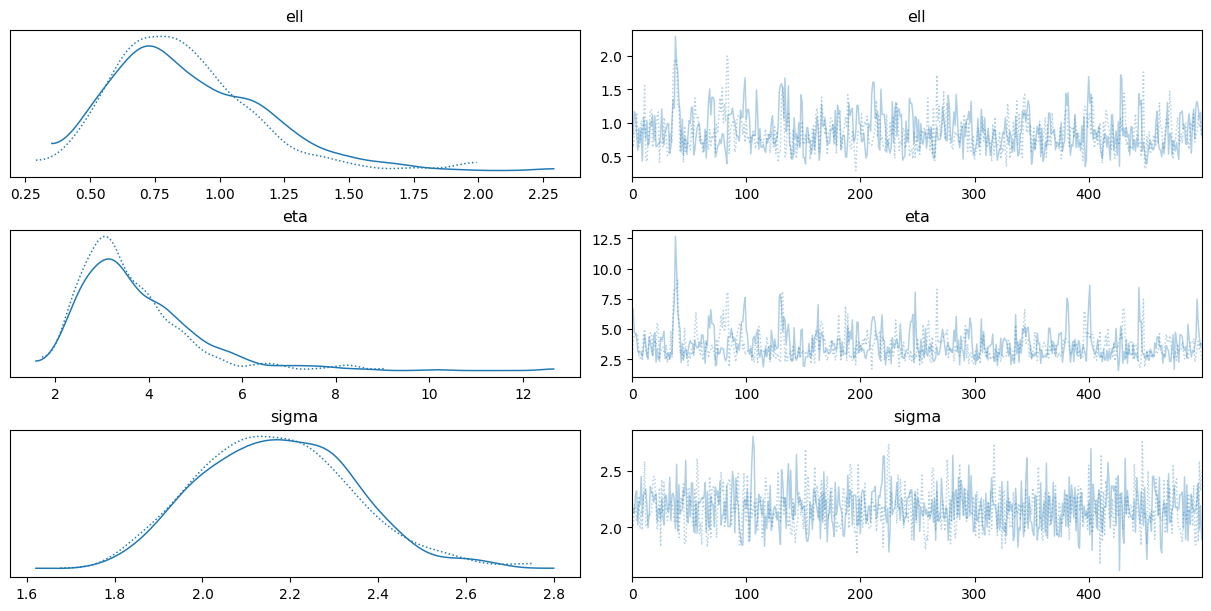

In [37]:
# Visualize posterior distributions
az.plot_trace(marginal_trace, var_names=['ell', 'eta', 'sigma'], backend_kwargs={'constrained_layout': True});

### Making Predictions

Now comes the exciting part: using our trained GP to make predictions at new input locations. We'll use the `conditional` method to compute the posterior predictive distribution.

In [38]:
# New X locations for prediction (including extrapolation)
X_new = np.linspace(-1, 12, 300)[:, None]

with marginal_model:
    # Conditional distribution for the latent function
    f_pred = gp.conditional('f_pred', X_new)
    
    # Sample from the posterior predictive
    marginal_ppc = pm.sample_posterior_predictive(
        marginal_trace,
        var_names=['f_pred'],
        random_seed=rng
    )

Sampling: [f_pred]


Output()

### Visualizing Posterior Predictions

Now comes the exciting part: can the GP recover the true latent function from noisy observations? Let's plot the posterior mean along with credible intervals to show our uncertainty. We'll also overlay the true function to see how close we got.

In [39]:
def plot_gp_posterior(ppc, X_pred, X_train, y_train, var_name='f_pred',
                      title='GP Posterior Predictions', xaxis_title='X', yaxis_title='Y',
                      show_training_range=True):

    f_pred_samples = ppc.posterior_predictive[var_name].values

    f_pred_mean = f_pred_samples.mean(axis=(0, 1))
    f_pred_lower = np.percentile(f_pred_samples, 2.5, axis=(0, 1))
    f_pred_upper = np.percentile(f_pred_samples, 97.5, axis=(0, 1))

    # Calculate y-axis range from data
    y_min = y_train.min()
    y_max = y_train.max()
    y_range = y_max - y_min
    y_padding = 0.1 * y_range  # 10% padding

    fig = go.Figure()
    
    fig.add_trace(go.Scatter(
        x=X_pred.flatten(),
        y=f_pred_upper,
        mode='lines',
        line=dict(width=0),
        showlegend=False,
        hoverinfo='skip'
    )).add_trace(go.Scatter(
        x=X_pred.flatten(),
        y=f_pred_lower,
        mode='lines',
        fill='tonexty',
        fillcolor='rgba(255, 0, 0, 0.2)',
        line=dict(width=0),
        name='95% Credible Interval'
    )).add_trace(go.Scatter(
        x=X_pred.flatten(),
        y=f_pred_mean,
        mode='lines',
        name='Posterior mean',
        line=dict(color='red', width=2)
    )).add_trace(go.Scatter(
        x=X_train.flatten(),
        y=y_train,
        mode='markers',
        name='Observed data',
        marker=dict(size=4, color='black')
    )).update_layout(
        title=title,
        xaxis_title=xaxis_title,
        yaxis_title=yaxis_title,
        yaxis=dict(range=[y_min - y_padding, y_max + y_padding]),
        hovermode='x unified',
        width=900,
        height=500,
    )
    
    return fig

plot_gp_posterior(
    marginal_ppc,
    X_new,
    X_train,
    y_train,
    title='GP Marginal: Posterior Predictions with Uncertainty',
    xaxis_title='Years since 1990',
    yaxis_title='CO₂ (ppm)'
)

### Interpreting the Predictions

Remarkable! The GP has successfully recovered the true latent function (blue line) from noisy observations:

**Within the training region** ($0 < x < 10$): The posterior mean (red line) tracks the true function closely. The 95% credible interval (shaded) captures the true function almost everywhere, reflecting appropriate uncertainty. Where observations are dense and informative, the credible interval is narrow. This is Bayesian inference at work—the data strongly constrain what the latent function could be.

**In extrapolation regions** ($x < 0$ or $x > 10$): Uncertainty grows rapidly. Without data to anchor predictions, the GP reverts to its prior belief: functions should stay near zero (the mean function) but could wander. Notice how the credible interval widens—this is the model honestly admitting "I don't know what happens out here."

**Key insight**: The GP didn't just fit a curve through the points—it learned the underlying **process** that generated the data. It inferred the lengthscale (how quickly correlations decay), the amplitude (vertical scale of variation), and the noise level (observation uncertainty). With these learned parameters, it reconstructed the latent function.

This is the power of `pm.gp.Marginal` for Gaussian likelihood problems: fast, exact inference that properly quantifies uncertainty.

## 🤖 EXERCISE: Explore Different Kernels

Now that you've seen a successful GP fit, try experimenting with different kernel choices!

### Your Task

Modify the model above to use different kernels and observe how they affect the fit. Try:

1. **ExpQuad kernel**: Replace `Matern52` with `ExpQuad`—does it over-smooth or under-smooth?
2. **Matérn 3/2 kernel**: Replace with `Matern32`—does it capture sharper features?
3. **Wrong lengthscale prior**: Change the lengthscale prior to `pm.Gamma('ell', alpha=20, beta=10)` (strong prior around 2.0)—does it still recover the truth?

Use your LLM to help you make these modifications and interpret the results.

Progress,Draws,Divergences,Step Size,Gradients/Draw
,1500,0,0.88,3
,1500,0,0.82,3


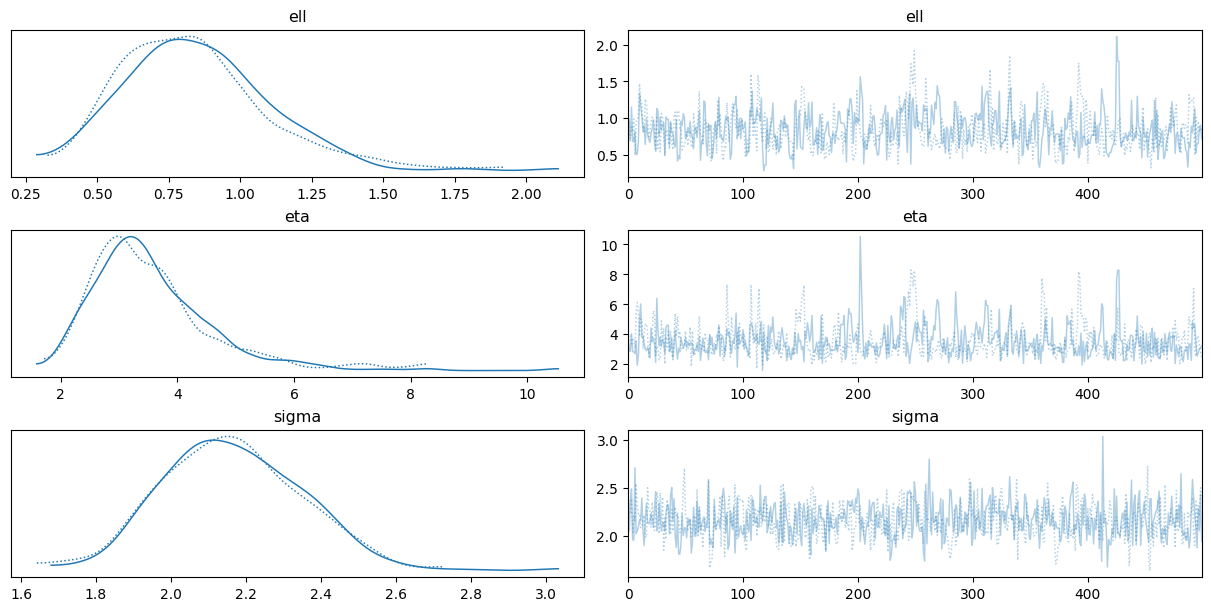

In [40]:
# 🤖 EXERCISE: Modify the kernel and re-fit

# Try different options:
# Option 1: ExpQuad kernel (infinitely smooth)
# cov_func = eta**2 * pm.gp.cov.ExpQuad(1, ell)

# Option 2: Matern32 kernel (once differentiable)
# cov_func = eta**2 * pm.gp.cov.Matern32(1, ell)

# Option 3: Strong lengthscale prior (potentially misspecified)
# ell = pm.Gamma('ell', alpha=20, beta=10)  # Strong prior around 2.0

with pm.Model() as exercise_model:
    ell = pm.Gamma('ell', alpha=2, beta=1)
    eta = pm.HalfCauchy('eta', beta=5)
    
    # MODIFY THIS LINE - try different kernels
    cov_func = eta**2 * pm.gp.cov.Matern52(1, ell)
    
    gp = pm.gp.Marginal(cov_func=cov_func)
    sigma = pm.HalfCauchy('sigma', beta=5)
    y_obs = gp.marginal_likelihood('y', X=X, y=y, sigma=sigma)
    
    exercise_trace = pm.sample(
        500,
        tune=1000,
        nuts_sampler='nutpie',
        chains=2,
        random_seed=rng
    )

# Visualize results
az.plot_trace(exercise_trace, var_names=['ell', 'eta', 'sigma'], backend_kwargs={'constrained_layout': True});

Let's plot the posterior predictions to see how your kernel choice affected the fit!

In [41]:
with exercise_model:
    f_pred = gp.conditional('f_pred', X_new)
    exercise_ppc = pm.sample_posterior_predictive(
        exercise_trace,
        var_names=['f_pred'],
        random_seed=rng
    )

# Plot using the same function
plot_gp_posterior(
    exercise_ppc,
    X_new,
    X,
    y,
    title='GP with Alternative Kernel',
    xaxis_title='X',
    yaxis_title='Y'
)

Sampling: [f_pred]


Output()

## Section 2.4: Latent GPs with pm.gp.Latent

While `pm.gp.Marginal` is efficient for Gaussian likelihoods, many real-world problems don't produce continuous measurements with Gaussian noise. Consider:

- **Classification**: Predicting whether a patient has a disease (binary outcome)
- **Count data**: Number of events in a time period (discrete, non-negative)
- **Survival analysis**: Time until an event occurs (censored data)

For these cases, we need `pm.gp.Latent`, which keeps the GP function as a latent variable in the model and allows arbitrary likelihood functions.

### The Latent GP Approach

Instead of marginalizing out the GP, we explicitly sample it:

$$
\begin{align}
f &\sim \mathcal{GP}(m, k) \\
y_i &\sim \text{Likelihood}(g(f(x_i)), \theta)
\end{align}
$$

where $g$ is a link function (like logistic for binary outcomes) and Likelihood can be any distribution (Bernoulli, Poisson, Student-T, etc.).

### Trade-offs: Latent vs Marginal

**pm.gp.Marginal**:
- ✓ Fast: analytically integrates out the GP
- ✓ Efficient: fewer parameters to sample
- ✗ Limited: only works with Gaussian likelihoods

**pm.gp.Latent**:
- ✓ Flexible: works with any likelihood
- ✓ Includes GP samples in posterior
- ✗ Slower: must sample high-dimensional latent function
- ✗ Can have sampling challenges

Let's work through a classification example to see `pm.gp.Latent` in action.

### Example: Poisson Regression for Count Data

Many real-world applications involve count data—discrete, non-negative outcomes like the number of events occurring in a time period. The **Poisson distribution** is the natural choice for modeling counts, and when we expect the rate to vary smoothly over time, a GP with Poisson likelihood becomes a powerful tool.

We'll work with the famous British coal mining disasters dataset, which records 191 mining disasters from 1851 to 1962. Our goal: model how the disaster rate changes over this period using a GP to capture smooth temporal trends without imposing a rigid parametric form.

The Poisson likelihood requires a positive rate parameter $\lambda$, so we'll use a **log link function**: the GP models $\log(\lambda)$, ensuring $\lambda > 0$. Let's load the data and bin it into annual counts.

In [64]:
# Load coal mining disasters data
coal_data_path = pm.get_data('coal.csv')
coal_df_raw = pl.read_csv(coal_data_path, has_header=False, new_columns=['year'])

print(f"Total disasters recorded: {len(coal_df_raw)}")
print(f"Time period: {coal_df_raw['year'].min():.1f} to {coal_df_raw['year'].max():.1f}")

# Bin into annual counts
# Create bins for each year from 1851 to 1963 (to capture all disasters)
year_min = int(np.floor(coal_df_raw['year'].min()))
year_max = int(np.ceil(coal_df_raw['year'].max()))

# Count disasters per year
year_counts = []
years = []
for year in range(year_min, year_max + 1):
    count = coal_df_raw.filter(
        (pl.col('year') >= year) & (pl.col('year') < year + 1)
    ).height
    year_counts.append(count)
    years.append(year)

# Create DataFrame with annual counts
df_coal = pl.DataFrame({
    'year': years,
    'count': year_counts,
    'year_scaled': [(y - year_min) for y in years]  # Years since 1851
})

print(f"\nAnnual counts range: {min(year_counts)} to {max(year_counts)}")
print(f"\nFirst few years:")
print(df_coal.head(10))

# Visualize the annual disaster counts
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df_coal['year_scaled'],
    y=df_coal['count'],
    mode='markers',
    name='Annual disaster count',
    marker=dict(size=6, color='black', opacity=0.7)
))

fig.update_layout(
    title='British Coal Mining Disasters (1851-1962)',
    xaxis_title='Years since 1851',
    yaxis_title='Number of disasters per year',
    hovermode='x unified',
    width=900,
    height=500
)

fig.show()

Total disasters recorded: 191
Time period: 1851.2 to 1962.2

Annual counts range: 0 to 6

First few years:
shape: (10, 3)
┌──────┬───────┬─────────────┐
│ year ┆ count ┆ year_scaled │
│ ---  ┆ ---   ┆ ---         │
│ i64  ┆ i64   ┆ i64         │
╞══════╪═══════╪═════════════╡
│ 1851 ┆ 4     ┆ 0           │
│ 1852 ┆ 5     ┆ 1           │
│ 1853 ┆ 4     ┆ 2           │
│ 1854 ┆ 1     ┆ 3           │
│ 1855 ┆ 0     ┆ 4           │
│ 1856 ┆ 4     ┆ 5           │
│ 1857 ┆ 3     ┆ 6           │
│ 1858 ┆ 4     ┆ 7           │
│ 1859 ┆ 0     ┆ 8           │
│ 1860 ┆ 6     ┆ 9           │
└──────┴───────┴─────────────┘


### Understanding the Coal Mining Data

Looking at the plot, we see clear temporal patterns in the annual disaster counts:

**Early period (1851-1890s)**: Disaster rates are notably higher, with several years experiencing 5-6 disasters. This reflects the dangerous conditions of 19th-century mining—inadequate safety regulations, primitive equipment, and poor ventilation.

**Later period (1900s onward)**: The disaster rate appears to decline, with most years having 0-2 disasters. This likely reflects improving safety standards, better mining technology, and stricter regulations following major disasters.

**Key observation**: The rate appears to change smoothly over time rather than in discrete jumps. This makes the coal mining dataset perfect for GP modeling—we want to capture this smooth temporal trend without assuming a specific parametric form (like exponential decay).

Notice these are **count data**—non-negative integers, not continuous values. A Gaussian likelihood would be inappropriate since it could predict negative disaster counts. The Poisson distribution is designed exactly for this type of data.

### Building the Poisson GP Model

Now we'll use `pm.gp.Latent` with a Poisson likelihood to model the disaster rate. The key modeling choices:

**Link function**: The Poisson distribution parameterizes the rate $\lambda > 0$, but our GP can range over all real numbers. We use the **log link**: $\log(\lambda) = f(t)$, which means $\lambda = \exp(f(t))$. This ensures the rate is always positive regardless of what the GP predicts.

**Kernel choice**: We'll use Matérn 5/2, which allows smooth but not infinitely smooth variations—appropriate for a disaster rate that might change gradually as mining practices evolve. A lengthscale prior that's weakly informative over the ~110-year timespan makes sense.

**Prior considerations**: We need to be thoughtful about the GP prior on the log-scale. Since disasters are relatively rare events (at most 6 per year), $\log(\lambda)$ should be modest—probably between -2 (≈0.14 disasters/year) and 2 (≈7.4 disasters/year).

In [65]:
# Prepare data for modeling
X_coal = df_coal['year_scaled'].to_numpy().reshape(-1, 1)
y_coal = df_coal['count'].to_numpy()

with pm.Model() as coal_model:
    # Hyperparameter priors
    # Lengthscale: expect variation on the scale of 10-30 years
    ell = pm.Gamma('ell', alpha=3, beta=0.2)
    
    # Amplitude: controls variation in log-rate
    eta = pm.HalfNormal('eta', sigma=2)
    
    # Covariance function - Matérn 5/2 for smooth but flexible trends
    cov_func = eta**2 * pm.gp.cov.Matern52(1, ell)
    
    # Latent GP
    gp = pm.gp.Latent(cov_func=cov_func)
    
    # GP prior - this is the log-rate
    f = gp.prior('f', X=X_coal)
    
    # Transform to rate via exponential (inverse of log link)
    lam = pm.Deterministic('lambda', pm.math.exp(f))
    
    # Poisson likelihood
    y_obs = pm.Poisson('y', mu=lam, observed=y_coal)
    
    # Sample from posterior
    coal_trace = pm.sample(
        500,
        tune=1000,
        nuts_sampler='nutpie',
        chains=2,
        target_accept=0.95,
        random_seed=rng
    )

Progress,Draws,Divergences,Step Size,Gradients/Draw
,1500,0,0.11,63
,1500,1,0.10,31


### Understanding the Poisson GP Structure

The critical components of this model differ from our earlier examples:

**`gp.prior('f', X=X_coal)`**: This explicitly samples the latent GP as a variable in our model. The vector `f` represents $\log(\lambda)$ at each year—the log-rate of disasters.

**`pm.Deterministic('lambda', pm.math.exp(f))`**: This is the **inverse link function**, transforming from log-rate to actual rate. By tracking it as a Deterministic variable, we can examine the disaster rate $\lambda$ directly in our posterior, not just the log-rate. This makes interpretation much easier.

**`pm.Poisson('y', mu=lam, observed=y_coal)`**: The Poisson likelihood connects our latent rate to the observed counts. This is fundamentally different from Gaussian or Bernoulli—the Poisson naturally handles non-negative integer counts and has variance equal to its mean.

**Why we can't use `pm.gp.Marginal`**: There's no way to analytically marginalize a Poisson likelihood. We must explicitly sample the latent function `f`, which is what `pm.gp.Latent` does. This makes inference slower but enables the flexibility to use non-Gaussian likelihoods.

Let's check how well sampling worked.

In [66]:
# Check convergence
summary_coal = az.summary(coal_trace, var_names=['ell', 'eta'])
print(summary_coal)

# Check divergences
divergences_coal = coal_trace.sample_stats['diverging'].sum().item()
print(f"\nNumber of divergences: {divergences_coal}")

if divergences_coal == 0:
    print("✓ No divergences - sampling worked well!")
else:
    print(f"⚠ Warning: {divergences_coal} divergences detected. Consider reparameterization.")

       mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
ell  19.950  7.280   8.153   32.975      0.410    0.389     311.0     404.0   
eta   0.967  0.372   0.375    1.654      0.023    0.025     285.0     287.0   

     r_hat  
ell   1.00  
eta   1.01  

Number of divergences: 1
⚠ Warning: 1 divergences detected. Consider reparameterization.


### Visualizing the Posterior Disaster Rate

Now let's see how well our GP captured the temporal trend in disaster rates. We'll plot the posterior mean rate $\lambda(t)$ along with credible intervals, overlaying the observed annual counts.

In [67]:
# Extract posterior samples for the rate parameter lambda
lambda_samples = coal_trace.posterior['lambda'].values

lambda_mean = lambda_samples.mean(axis=(0, 1))
lambda_lower = np.percentile(lambda_samples, 2.5, axis=(0, 1))
lambda_upper = np.percentile(lambda_samples, 97.5, axis=(0, 1))

# Create visualization
fig = go.Figure()

# 95% credible interval for rate
fig.add_trace(go.Scatter(
    x=df_coal['year_scaled'],
    y=lambda_upper,
    mode='lines',
    line=dict(width=0),
    showlegend=False,
    hoverinfo='skip'
))

fig.add_trace(go.Scatter(
    x=df_coal['year_scaled'],
    y=lambda_lower,
    mode='lines',
    fill='tonexty',
    fillcolor='rgba(255, 0, 0, 0.2)',
    line=dict(width=0),
    name='95% Credible Interval'
))

# Posterior mean rate
fig.add_trace(go.Scatter(
    x=df_coal['year_scaled'],
    y=lambda_mean,
    mode='lines',
    name='Posterior mean rate λ(t)',
    line=dict(color='red', width=2)
))

# Observed annual counts
fig.add_trace(go.Scatter(
    x=df_coal['year_scaled'],
    y=df_coal['count'],
    mode='markers',
    name='Observed annual counts',
    marker=dict(size=6, color='black', opacity=0.6)
))

fig.update_layout(
    title='GP Poisson Regression: Coal Mining Disaster Rate Over Time',
    xaxis_title='Years since 1851',
    yaxis_title='Disaster rate (disasters/year)',
    hovermode='x unified',
    width=900,
    height=500
)

fig.show()

### Interpreting the Poisson GP Results

This is a beautiful demonstration of GP flexibility with non-Gaussian likelihoods. The posterior mean rate (red line) captures the historical trend in coal mining disasters:

**Early period (1851-1890s)**: The estimated disaster rate is high, around 3-4 disasters per year. The model has learned that Victorian-era mining was substantially more dangerous, reflected in the elevated rate during this period.

**Transition period (~1890-1900)**: The rate begins to decline as safety practices gradually improved. The GP smoothly captures this transition without us imposing any particular functional form—no exponential decay, no linear trend, just letting the data speak.

**Later period (1900-1962)**: The disaster rate settles to a lower level, around 1-2 disasters per year. While still tragic, this represents a substantial improvement from the earlier period.

**Uncertainty quantification**: The credible interval (shaded region) reflects our uncertainty about the true underlying rate. Notice it's wider in periods with high variability in the observed counts—the Poisson variance equals its mean, so high-rate periods naturally have more scatter.

**The power of the log link**: By modeling $\log(\lambda)$ with a GP and exponentiating, we guaranteed $\lambda > 0$ throughout. This is essential for count data—we never predict negative disaster rates, even though our GP can range over all real numbers.

**Key insight**: This model discovered the declining disaster rate entirely from data, without us specifying when or how the change occurred. The GP's smoothness prior (via the Matérn 5/2 kernel) encouraged gradual changes, but the data ultimately determined the shape of the trend.

Now let's move on to one of the most powerful features of GPs: kernel composition.

## 🤖 EXERCISE: Fitting a GP to Atmospheric CO₂ Data

Now it's your turn to fit a GP model to real-world data. We'll use the famous Mauna Loa CO₂ dataset—the "Keeling Curve"—which has become one of the most important scientific time series in climate science.

### Understanding the Mauna Loa CO₂ Dataset

Since 1958, researchers at the Mauna Loa Observatory in Hawaii have continuously measured atmospheric CO₂ concentrations. This remote location in the middle of the Pacific Ocean provides measurements relatively free from local pollution sources, making it an ideal monitoring station for global atmospheric composition.

The Keeling Curve exhibits two striking patterns that you'll notice when you plot the data:

1. **Long-term increasing trend** (decades-scale) due to cumulative anthropogenic emissions from fossil fuels, deforestation, and industrial activity
2. **Annual seasonal cycles** (yearly oscillations) due to Northern Hemisphere vegetation dynamics—plants absorb CO₂ during spring/summer growth and release it during fall/winter decay

For this exercise, we'll focus on a 10-year window (1990-2000) to keep the computation manageable.

In [70]:
# Load Mauna Loa CO2 data from PyMC datasets
# First, get the file path and load with polars
co2_file = pm.get_data("monthly_in_situ_co2_mlo.csv")

# Load with polars, skipping the header rows
df_raw = pl.read_csv(
    co2_file,
    skip_rows=57,  # Skip metadata header
    has_header=False,
    null_values=["-99.99"],  # Handle missing value indicator
    schema_overrides={
        "column_1": pl.Int64,    # year
        "column_2": pl.Int64,    # month
        "column_3": pl.Float64,  # decimal_date
        "column_4": pl.Float64,  # monthly_avg
        "column_5": pl.Float64,  # CO2
        "column_6": pl.Float64,  # seasonally_adjusted
        "column_7": pl.Float64,  # fit
        "column_8": pl.Float64,  # seasonally_adjusted_fit
        "column_9": pl.Float64,  # CO2_filled
        "column_10": pl.Float64, # seasonally_adjusted_filled
    }
)

# Assign column names
df_raw.columns = [
    "year", "month", "decimal_date", "monthly_avg", "CO2", "seasonally_adjusted",
    "fit", "seasonally_adjusted_fit", "CO2_filled", "seasonally_adjusted_filled"
]

# Filter to 1990-2000 period and create time variable
df_co2 = (
    df_raw
    .filter((pl.col("year") >= 1990) & (pl.col("year") < 2000))
    .with_columns(
        (pl.col("year") + (pl.col("month") - 1) / 12 - 1990).alias("time")
    )
    .select(["time", "CO2"])
    .drop_nulls()
)

X_co2 = df_co2.select("time").to_numpy().reshape(-1, 1)
y_co2 = df_co2.select("CO2").to_numpy().flatten()

print(f"Data shape: {X_co2.shape[0]} monthly observations from 1990-2000")
print(f"CO2 range: {y_co2.min():.2f} to {y_co2.max():.2f} ppm")

go.Figure().add_trace(go.Scatter(
    x=df_co2["time"].to_numpy(),
    y=df_co2["CO2"].to_numpy(),
    mode="markers",
    marker=dict(size=4, color="steelblue"),
    name="Observed CO₂"
)).update_layout(
    title="Atmospheric CO₂ at Mauna Loa (1990-2000)",
    xaxis_title="Years since 1990",
    yaxis_title="CO₂ Concentration (ppm)",
    height=400
)

Data shape: 120 monthly observations from 1990-2000
CO2 range: 350.77 to 371.04 ppm


### Your Task

Build a simple GP model using **either `pm.gp.Marginal` or `pm.gp.Latent`** to fit the CO₂ data. You'll need to:

1. Load and prepare the data (code provided below)
2. Choose an appropriate kernel (think about what patterns you're trying to capture)
3. Define priors for the kernel hyperparameters
4. Fit the model and generate predictions
5. Visualize the fit

Don't worry if your fit doesn't capture all the patterns perfectly—that's intentional! In the next section, we'll see how to improve this model dramatically using additive kernels.

**Prompt suggestion**: "Help me implement a GP regression model in PyMC to fit atmospheric CO₂ data. Use either Marginal or Latent formulation with an appropriate kernel, priors for lengthscale and amplitude, and generate posterior predictions with uncertainty bands."


In [ ]:
# YOUR LLM-ASSISTED CODE HERE
# Build your GP model below. Consider:
# - Which kernel captures smooth variation?
# - What are reasonable lengthscale values for data spanning 10 years?
# - Should you use Marginal (Gaussian likelihood) or Latent?
# - How will you handle the observation noise?

def fit_simple_co2_gp(X, y):
    """
    Fit a GP model to CO2 data.
    
    Parameters
    ----------
    X : array, shape (n, 1)
        Time points (years since 1990)
    y : array, shape (n,)
        CO2 concentrations (ppm)
    
    Returns
    -------
    model : pm.Model
        The fitted PyMC model
    trace : az.InferenceData
        Posterior samples
    """
    # YOUR CODE HERE
    pass

# Test your implementation
# model_co2, trace_co2 = fit_simple_co2_gp(X_co2, y_co2)
# az.summary(trace_co2, var_names=['ell', 'eta', 'sigma'])

Data shape: 120 monthly observations from 1990-2000
CO2 range: 350.77 to 371.04 ppm


### Reflecting on Your Simple GP Fit

Once you've fit your model, take a moment to examine the results carefully. If you used a single smooth kernel like ExpQuad or Matérn, you likely noticed something important: **the model had to make a compromise**.

**If you chose a short lengthscale**: The GP might have captured some of the seasonal oscillations, but at the cost of creating unrealistic wiggles in the long-term trend. The model is trying to fit both patterns with a single smoothness parameter, and it's struggling.

**If you chose a long lengthscale**: The GP might have captured the decade-scale upward trend beautifully, giving you a smooth increasing curve. But look closely at the residuals—you'll see a clear annual pattern that the model completely missed. The seasonal cycle is still there in the data; your model just couldn't see it.

**This is the fundamental limitation**: A single kernel with one lengthscale can only capture variation at one characteristic timescale. The CO₂ data has variation at **two very different timescales**—years (trend) and months (seasonality)—and they arise from completely independent physical processes.

Here's the key insight: these patterns don't interact; they simply add together. The long-term trend from fossil fuel emissions doesn't change the seasonal amplitude, and the seasonal cycle from vegetation doesn't affect the long-term trend. They're independent sources of variation.

This is exactly the scenario where **additive kernels** shine. In the next section, we'll see how combining kernels through addition allows us to model both patterns simultaneously, each with its own characteristic lengthscale. The improvement will be dramatic.

## Section 2.5: Additive and Multiplicative Kernels

One of the most powerful features of GPs is that we can **compose kernels** through addition and multiplication. This allows us to build sophisticated models that capture multiple patterns simultaneously—exactly what we need for the CO₂ data you just worked with.

### The Algebra of Kernels

If $k_1$ and $k_2$ are valid covariance functions, then:

**Addition ($k_1 + k_2$)**: The resulting function is a sum of independent components
- Use when: You have multiple independent sources of variation (e.g., trend + seasonality)
- Interpretation: Functions can vary in ways explained by *either* kernel

**Multiplication ($k_1 \times k_2$)**: The resulting function has features of both kernels interacting
- Use when: One pattern modulates another (e.g., growing seasonal amplitude)
- Interpretation: Functions must satisfy *both* kernels' constraints simultaneously

Let's see how this works by revisiting the CO₂ data with an additive kernel approach.

### Additive Kernels for the CO₂ Data

Let's return to the Mauna Loa CO₂ data from the previous exercise and see how additive kernels solve the problem you likely encountered. Remember, a single kernel had to compromise between capturing the long-term trend and the seasonal oscillations.

The solution is remarkably elegant: we'll use **two kernels added together**, each modeling a different physical process:

1. **ExpQuad kernel with long lengthscale**: Captures the smooth decade-scale trend from cumulative emissions
2. **Periodic kernel with 1-year period**: Captures the annual seasonal cycle from vegetation dynamics

When we add these kernels, $k_{\text{total}} = k_{\text{trend}} + k_{\text{seasonal}}$, the resulting GP can simultaneously model both patterns, each with appropriate characteristic scales. Let's build this model.

We'll use the same data you loaded in the previous exercise (`X_co2` and `y_co2`). Now let's build an additive model that combines a smooth trend kernel with a periodic seasonal kernel.

### Observing the Independent Patterns

Looking at the data, two distinct patterns are immediately apparent:

**The long-term trend**: CO₂ concentrations rise steadily over the decade, from ~355 ppm in 1990 to ~370 ppm in 2000. This reflects cumulative emissions from fossil fuel combustion and land use changes.

**The seasonal cycle**: Regular oscillations repeat annually with an amplitude of about 5-7 ppm. Each spring, CO₂ concentrations drop as Northern Hemisphere plants leaf out and photosynthesize. Each fall, concentrations rise as plants shed leaves and decomposition releases CO₂.

The key insight: these patterns arise from **independent physical processes**. The trend results from anthropogenic emissions. The seasonal cycle results from the terrestrial biosphere's annual growth/decay cycle. Neither process modulates the other—they simply add together.

This is exactly when we need an additive kernel: $k_{\text{total}} = k_{\text{trend}} + k_{\text{seasonal}}$. Let's build the model.

### Building an Additive GP: Trend + Seasonal Components

We'll use an **additive kernel** to model the trend and seasonality as independent components:

- **Matérn 5/2 kernel** with a long lengthscale for the decadal trend
- **Periodic kernel** with period=1 year for the seasonal oscillations

The mathematical insight: when we add kernels, the resulting GP's covariance function is

$$
k_{\text{total}}(x, x') = k_{\text{trend}}(x, x') + k_{\text{seasonal}}(x, x')
$$

This means the **total variance** is the sum of variances from each component. Each kernel can explain different aspects of the data independently. The GP will automatically learn how much variation to attribute to the trend versus the seasonal cycle.

Let's implement this model.

In [49]:
with pm.Model() as additive_co2_model:
    # Trend component: smooth, long-term variation
    ell_trend = pm.Gamma('ell_trend', alpha=2, beta=0.5)  # Prior favors larger lengthscales
    eta_trend = pm.HalfNormal('eta_trend', sigma=10)  # Allow for substantial trend magnitude
    cov_trend = eta_trend**2 * pm.gp.cov.Matern52(1, ell_trend)
    
    # Seasonal component: periodic with yearly period
    ell_seasonal = pm.Gamma('ell_seasonal', alpha=2, beta=2)
    eta_seasonal = pm.HalfNormal('eta_seasonal', sigma=5)  # Seasonal amplitude ~3-7 ppm
    period = 1.0  # One year
    cov_seasonal = eta_seasonal**2 * pm.gp.cov.Periodic(1, period=period, ls=ell_seasonal)
    
    # ADDITIVE KERNEL: sum of trend and seasonal
    cov_total = cov_trend + cov_seasonal
    
    # GP with additive kernel
    gp = pm.gp.Marginal(cov_func=cov_total)
    
    # Likelihood
    sigma = pm.HalfNormal('sigma', sigma=1)  # Measurement noise
    y_obs = gp.marginal_likelihood('y', X=X_co2, y=y_co2, sigma=sigma)
    
    # Sample
    additive_co2_trace = pm.sample(
        500,
        tune=1000,
        nuts_sampler='nutpie',
        chains=2,
        random_seed=rng
    )

Progress,Draws,Divergences,Step Size,Gradients/Draw
,1500,0,0.83,7
,1500,1,0.85,7


### Understanding the Additive Model Structure

The critical line is `cov_total = cov_trend + cov_seasonal`. This creates a new covariance function where:

- The **trend component** can vary slowly over years, capturing the decadal increase in CO₂
- The **seasonal component** can oscillate with a one-year period, capturing the annual vegetation cycle
- The **total variation** is the sum of both—they contribute independently

We gave each component its own hyperparameters:
- `ell_trend`, `eta_trend`: Control how smooth and how large the long-term trend is
- `ell_seasonal`, `eta_seasonal`: Control how smooth each annual cycle is and how large the seasonal amplitude is

The model will learn these parameters from the data, effectively **decomposing** the CO₂ signal into its constituent physical processes.

Let's visualize the results to see how well the additive kernel captures both patterns.

In [50]:
# Make predictions (including slight extrapolation)
X_pred_co2 = np.linspace(-0.5, 11, 400)[:, None]

with additive_co2_model:
    f_pred_co2 = gp.conditional('f_pred', X_pred_co2)
    ppc_co2 = pm.sample_posterior_predictive(
        additive_co2_trace,
        var_names=['f_pred'],
        random_seed=rng
    )

Sampling: [f_pred]


Output()

In [52]:
# Extract predictions
f_pred_co2_samples = ppc_co2.posterior_predictive['f_pred'].values

f_pred_co2_mean = f_pred_co2_samples.mean(axis=(0, 1))
f_pred_co2_lower = np.percentile(f_pred_co2_samples, 2.5, axis=(0, 1))
f_pred_co2_upper = np.percentile(f_pred_co2_samples, 97.5, axis=(0, 1))

# Visualize
fig = go.Figure()

# Credible interval
fig.add_trace(go.Scatter(
    x=X_pred_co2.flatten(),
    y=f_pred_co2_upper,
    mode='lines',
    line=dict(width=0),
    showlegend=False,
    hoverinfo='skip'
))

fig.add_trace(go.Scatter(
    x=X_pred_co2.flatten(),
    y=f_pred_co2_lower,
    mode='lines',
    fill='tonexty',
    fillcolor='rgba(255, 0, 0, 0.2)',
    line=dict(width=0),
    name='95% Credible Interval'
))

# Posterior mean
fig.add_trace(go.Scatter(
    x=X_pred_co2.flatten(),
    y=f_pred_co2_mean,
    mode='lines',
    name='Posterior mean (trend + seasonal)',
    line=dict(color='red', width=2)
))

# Observed data
fig.add_trace(go.Scatter(
    x=df_co2['time'],
    y=df_co2['co2'],
    mode='markers',
    name='Observed CO₂',
    marker=dict(size=4, color='black', opacity=0.6)
))

fig.update_layout(
    title='Additive GP: Trend + Seasonal Components',
    xaxis_title='Years since 1990',
    yaxis_title='CO₂ concentration (ppm)',
    hovermode='x unified',
    width=900,
    height=500
)

fig.show()

### Interpreting the Additive Model Results

Beautiful! The additive GP has successfully decomposed the Mauna Loa CO₂ data into its constituent patterns:

**The trend component** captures the steady decade-long increase from fossil fuel emissions. The model learned that this variation happens on a time scale of years, with a large lengthscale parameter.

**The seasonal component** captures the annual oscillations from vegetation dynamics. The model learned that this pattern repeats exactly every year (period=1.0) with an amplitude of several ppm.

**The combined fit** (red line) shows how these independent patterns add together to explain the observations. The 95% credible interval (shaded) reflects our uncertainty—notice it grows slightly when extrapolating beyond year 10.

This is the power of additive models: when your data contains multiple **independent** sources of variation, each kernel explains a different aspect. The GP automatically learns how to decompose the signal based on the different correlation structures (long-term smooth trend vs. yearly periodic cycle).

**Key intuition**: Addition works when patterns don't interact—when one doesn't modulate the other. The CO₂ trend doesn't change the seasonal amplitude, and the seasonal cycle doesn't affect the long-term trend. They're independent physical processes that simply superimpose.

Now let's see what happens when patterns **do** interact—that's where multiplicative kernels come in.

### Multiplicative Kernels: When Patterns Interact

Multiplication creates more complex behaviors. A product $k_1 \times k_2$ forces the function to satisfy both kernels' constraints simultaneously. This is useful when one pattern **modulates** another.

For example: imagine seasonal patterns whose amplitude grows over time. A purely additive model can't capture this—the seasonal oscillations would have constant amplitude. A multiplicative kernel can.

Let's create synthetic data with growing seasonal amplitude and model it.

In [53]:
# Create data with growing seasonal amplitude
X_mult = np.linspace(0, 5, 200)[:, None]

# Seasonal pattern with amplitude that grows linearly
amplitude = 1 + 0.5 * X_mult.flatten()
y_mult = amplitude * np.sin(4 * np.pi * X_mult.flatten()) + 0.3 * rng.standard_normal(200)

df_mult = pl.DataFrame({
    'x': X_mult.flatten(),
    'y': y_mult
})

# Visualize
fig = px.scatter(
    df_mult.to_pandas(),
    x='x',
    y='y',
    title='Data with Growing Seasonal Amplitude'
)
fig.update_traces(marker=dict(size=4, color='black'))
fig.update_layout(width=900, height=500)
fig.show()

### Observing the Multiplicative Pattern

Notice how the oscillations grow in amplitude as x increases. An additive model `Linear + Periodic` couldn't capture this—it would just add a linear trend to constant-amplitude oscillations.

Instead, we need `Linear × Periodic`, where the linear component modulates the amplitude of the periodic component.

In [54]:
with pm.Model() as mult_model:
    # Linear component for growing amplitude
    c = pm.Normal('c', mu=0, sigma=2)
    var_lin = pm.HalfNormal('var_lin', sigma=2)
    cov_linear = var_lin * pm.gp.cov.Linear(1, c=c)
    
    # Periodic component
    ell_per = pm.Gamma('ell_per', alpha=2, beta=2)
    eta_per = pm.HalfNormal('eta_per', sigma=2)
    period = 1.0
    cov_periodic = eta_per**2 * pm.gp.cov.Periodic(1, period=period, ls=ell_per)
    
    # MULTIPLICATIVE KERNEL
    cov_mult = cov_linear * cov_periodic
    
    gp = pm.gp.Marginal(cov_func=cov_mult)
    
    sigma = pm.HalfNormal('sigma', sigma=1)
    y_obs = gp.marginal_likelihood('y', X=X_mult, y=y_mult, sigma=sigma)
    
    mult_trace = pm.sample(
        500,
        tune=1000,
        nuts_sampler='nutpie',
        chains=2,
        random_seed=rng
    )

Progress,Draws,Divergences,Step Size,Gradients/Draw
,1500,0,0.49,7
,1500,0,0.44,15


### Understanding the Multiplicative Model

The line `cov_mult = cov_linear * cov_periodic` creates a kernel where:
- The periodic component creates oscillations
- The linear component modulates their amplitude
- Together, they create growing seasonal patterns

Let's see how well it works.

In [55]:
# Predictions
X_pred_mult = np.linspace(-0.5, 6, 300)[:, None]

with mult_model:
    f_pred_mult = gp.conditional('f_pred', X_pred_mult)
    ppc_mult = pm.sample_posterior_predictive(
        mult_trace,
        var_names=['f_pred'],
        random_seed=rng
    )

Sampling: [f_pred]


Output()

In [56]:
# Extract and visualize
f_pred_mult_samples = ppc_mult.posterior_predictive['f_pred'].values

f_pred_mult_mean = f_pred_mult_samples.mean(axis=(0, 1))
f_pred_mult_lower = np.percentile(f_pred_mult_samples, 2.5, axis=(0, 1))
f_pred_mult_upper = np.percentile(f_pred_mult_samples, 97.5, axis=(0, 1))

fig = go.Figure()

# Credible interval
fig.add_trace(go.Scatter(
    x=X_pred_mult.flatten(),
    y=f_pred_mult_upper,
    mode='lines',
    line=dict(width=0),
    showlegend=False
))

fig.add_trace(go.Scatter(
    x=X_pred_mult.flatten(),
    y=f_pred_mult_lower,
    mode='lines',
    fill='tonexty',
    fillcolor='rgba(255, 0, 0, 0.2)',
    line=dict(width=0),
    name='95% CI'
))

# Mean
fig.add_trace(go.Scatter(
    x=X_pred_mult.flatten(),
    y=f_pred_mult_mean,
    mode='lines',
    name='Posterior mean',
    line=dict(color='red', width=2)
))

# Data
fig.add_trace(go.Scatter(
    x=df_mult['x'],
    y=df_mult['y'],
    mode='markers',
    name='Data',
    marker=dict(size=4, color='black')
))

fig.update_layout(
    title='Multiplicative GP: Growing Seasonal Amplitude',
    xaxis_title='X',
    yaxis_title='Y',
    hovermode='x unified',
    width=900,
    height=500
)

fig.show()

### Interpreting the Multiplicative Results

Beautiful! The model has captured the growing amplitude of the oscillations. Notice how:
- The oscillation frequency stays constant (determined by the periodic kernel)
- The amplitude grows linearly (determined by the linear kernel)
- The interaction between them creates the observed pattern

When you extrapolate past $x=5$, the model continues this pattern—oscillations with ever-growing amplitude. This is sometimes exactly what you want, but be cautious: multiplicative models can extrapolate in surprising ways.

**Key takeaway**: Use multiplication when one pattern modulates another. Use addition when patterns are independent sources of variation.

## 🤖 EXERCISE 2: Additive Kernel Model

Your turn! Build an additive GP model that combines a long-term trend with seasonal variation.

### Task

Complete the function below that builds an additive GP model combining:
1. A Matérn 5/2 kernel for the trend (with long lengthscale)
2. A Periodic kernel for seasonality (with specified period)
3. Use `pm.gp.Marginal` for efficient inference

**Prompt suggestion**: "Help me define and fit an additive GP in PyMC that models a long-term trend using Matern52 and a seasonal component using Periodic kernel. The model should combine them with addition and use pm.gp.Marginal."

In [57]:
def additive_trend_seasonality_gp(X, y, period=1.0):
    """
    Combine ExpQuad/Matern (trend) plus Periodic (seasonality) in pm.gp.Marginal.
    
    Parameters
    ----------
    X : array, shape (n, 1)
        Input time points
    y : array, shape (n,)
        Observations
    period : float
        Period of seasonal variation
    
    Returns
    -------
    model : pm.Model
        The PyMC model
    trace : az.InferenceData
        Posterior samples
    """
    # YOUR LLM-ASSISTED CODE HERE
    # Hints:
    # - Use separate hyperparameters for trend and seasonal components
    # - Combine kernels with: cov_total = cov_trend + cov_seasonal
    # - Don't forget to specify sigma for observation noise
    pass

# Test your implementation
# model, trace = additive_trend_seasonality_gp(X_train_births, y_train_births, period=1.0)

## Section 2.6: Non-Gaussian Likelihoods - Robust Regression with Student-T

So far, we've used Gaussian noise (in `pm.gp.Marginal`) or Bernoulli outcomes (in classification). But real data often contains **outliers**—observations that don't fit the typical pattern. Gaussian distributions are not robust to outliers: a single extreme value can dramatically affect inference.

The **Student-T distribution** offers a robust alternative. It has heavier tails than a Gaussian, meaning it assigns higher probability to extreme values. This makes it much more tolerant of outliers.

### Why Student-T for Robust Regression?

The Student-T distribution has three parameters:
- **Location ($\mu$)**: The center, similar to the mean
- **Scale ($\sigma$)**: The spread, similar to standard deviation
- **Degrees of freedom ($\nu$)**: Controls tail heaviness

The degrees of freedom parameter is key:
- Small $\nu$ (e.g., 2-5) → very heavy tails, very robust to outliers
- Large $\nu$ (> 30) → approaches normal distribution

Since we need `pm.gp.Latent` for non-Gaussian likelihoods, let's see robust regression in action with Student-T likelihood.

### Example: Data with Outliers

Let's generate data where most observations are clean, but a few are extreme outliers.

In [58]:
# Generate data with outliers
n_robust = 100
X_robust = np.linspace(0, 10, n_robust)[:, None]

# True function
f_true_robust = 2 * np.sin(1.5 * X_robust.flatten())

# Most observations have small Gaussian noise
y_robust = f_true_robust + 0.3 * rng.standard_normal(n_robust)

# Add outliers: replace 10% of points with extreme values
n_outliers = 10
outlier_indices = rng.choice(n_robust, size=n_outliers, replace=False)
y_robust[outlier_indices] += rng.choice([-1, 1], size=n_outliers) * rng.uniform(3, 6, size=n_outliers)

df_robust = pl.DataFrame({
    'x': X_robust.flatten(),
    'y': y_robust,
    'f_true': f_true_robust,
    'is_outlier': [i in outlier_indices for i in range(n_robust)]
})

# Visualize
fig = go.Figure()

# Regular points
df_regular = df_robust.filter(pl.col('is_outlier') == False)
fig.add_trace(go.Scatter(
    x=df_regular['x'],
    y=df_regular['y'],
    mode='markers',
    name='Regular observations',
    marker=dict(size=5, color='black')
))

# Outliers
df_outlier = df_robust.filter(pl.col('is_outlier') == True)
fig.add_trace(go.Scatter(
    x=df_outlier['x'],
    y=df_outlier['y'],
    mode='markers',
    name='Outliers',
    marker=dict(size=8, color='red', symbol='x')
))

# True function
fig.add_trace(go.Scatter(
    x=df_robust['x'],
    y=df_robust['f_true'],
    mode='lines',
    name='True function',
    line=dict(color='dodgerblue', width=3)
))

fig.update_layout(
    title='Data with Outliers',
    xaxis_title='X',
    yaxis_title='Y',
    hovermode='x unified',
    width=900,
    height=500
)

fig.show()

### Observing the Outliers

The red X markers show outliers—observations that are far from the true function (blue line). If we used a Gaussian likelihood, these outliers would pull our posterior predictions toward them, distorting our estimate of the true function.

Let's build a robust model using a Student-T likelihood with `pm.gp.Latent`.

In [59]:
with pm.Model() as robust_model:
    # Hyperparameters
    ell = pm.Gamma('ell', alpha=2, beta=1)
    eta = pm.HalfNormal('eta', sigma=3)
    
    # Covariance function
    cov_func = eta**2 * pm.gp.cov.Matern52(1, ell)
    
    # Latent GP
    gp = pm.gp.Latent(cov_func=cov_func)
    f = gp.prior('f', X=X_robust)
    
    # Student-T likelihood for robustness
    sigma = pm.HalfNormal('sigma', sigma=1)
    nu = pm.Gamma('nu', alpha=2, beta=0.1)  # Prior favors low nu (heavy tails)
    
    y_obs = pm.StudentT(
        'y',
        mu=f,
        sigma=sigma,
        nu=nu,
        observed=y_robust
    )
    
    # Sample
    robust_trace = pm.sample(
        500,
        tune=1000,
        nuts_sampler='nutpie',
        chains=2,
        target_accept=0.95,
        random_seed=rng
    )

Progress,Draws,Divergences,Step Size,Gradients/Draw
,1500,0,0.05,255
,1500,0,0.04,255


### Understanding the Robust Model

The key difference from our earlier Gaussian models is the likelihood:

```python
y_obs = pm.StudentT('y', mu=f, sigma=sigma, nu=nu, observed=y_robust)
```

We're learning the degrees of freedom parameter `nu` from the data. The prior `Gamma(2, 0.1)` suggests we expect heavy tails (small nu), but leaves room for the data to tell us otherwise.

Let's see how well this handles the outliers.

In [60]:
# Check the learned nu parameter
nu_summary = az.summary(robust_trace, var_names=['nu'])
print("Degrees of freedom posterior:")
print(nu_summary)
print(f"\nMean nu: {nu_summary['mean'].values[0]:.2f}")
print("(Small nu indicates heavy tails were needed)")

Degrees of freedom posterior:
     mean   sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
nu  1.137  0.2   0.775    1.491      0.006    0.007    1132.0     789.0    1.0

Mean nu: 1.14
(Small nu indicates heavy tails were needed)


### Making Robust Predictions

Now let's predict and see if the model successfully ignored the outliers.

In [61]:
# Predictions
X_pred_robust = np.linspace(-1, 11, 300)[:, None]

with robust_model:
    f_pred_robust = gp.conditional('f_pred', X_pred_robust)
    ppc_robust = pm.sample_posterior_predictive(
        robust_trace,
        var_names=['f_pred'],
        random_seed=rng
    )

Sampling: [f_pred]


Output()

In [62]:
# Extract and visualize
f_pred_robust_samples = ppc_robust.posterior_predictive['f_pred'].values

f_pred_robust_mean = f_pred_robust_samples.mean(axis=(0, 1))
f_pred_robust_lower = np.percentile(f_pred_robust_samples, 2.5, axis=(0, 1))
f_pred_robust_upper = np.percentile(f_pred_robust_samples, 97.5, axis=(0, 1))

fig = go.Figure()

# Credible interval
fig.add_trace(go.Scatter(
    x=X_pred_robust.flatten(),
    y=f_pred_robust_upper,
    mode='lines',
    line=dict(width=0),
    showlegend=False
))

fig.add_trace(go.Scatter(
    x=X_pred_robust.flatten(),
    y=f_pred_robust_lower,
    mode='lines',
    fill='tonexty',
    fillcolor='rgba(255, 0, 0, 0.2)',
    line=dict(width=0),
    name='95% CI'
))

# Posterior mean
fig.add_trace(go.Scatter(
    x=X_pred_robust.flatten(),
    y=f_pred_robust_mean,
    mode='lines',
    name='Posterior mean',
    line=dict(color='red', width=2)
))

# True function
fig.add_trace(go.Scatter(
    x=df_robust['x'],
    y=df_robust['f_true'],
    mode='lines',
    name='True function',
    line=dict(color='dodgerblue', width=2, dash='dash')
))

# Regular data
fig.add_trace(go.Scatter(
    x=df_regular['x'],
    y=df_regular['y'],
    mode='markers',
    name='Regular observations',
    marker=dict(size=5, color='black')
))

# Outliers
fig.add_trace(go.Scatter(
    x=df_outlier['x'],
    y=df_outlier['y'],
    mode='markers',
    name='Outliers',
    marker=dict(size=8, color='red', symbol='x')
))

fig.update_layout(
    title='Robust GP with Student-T Likelihood',
    xaxis_title='X',
    yaxis_title='Y',
    hovermode='x unified',
    width=900,
    height=500
)

fig.show()

### Interpreting the Robust Results

Excellent! The posterior mean (red line) closely follows the true function (blue dashed line), essentially ignoring the outliers (red X markers). The Student-T likelihood has successfully downweighted the extreme observations.

Compare this to what would happen with a Gaussian likelihood—the outliers would pull the predicted function toward them, creating bulges in the estimate. The Student-T likelihood's heavy tails allow the model to say "these observations are just noise from the tail of the distribution," rather than trying to fit them.

**When to use robust likelihoods**:
- When you suspect your data contains outliers
- When measurement errors might occasionally be much larger than usual
- When you want your model to be less sensitive to a few extreme values

The cost is slower sampling (since we use `pm.gp.Latent`), but the benefit is much more reliable inference in the presence of outliers.

## 🤖 EXERCISE 3: Compare Marginal vs Latent GPs

Your final exercise: implement both approaches on the same dataset and compare their speed and accuracy.

### Task

Complete the function below that:
1. Fits the same data with both `pm.gp.Marginal` (Gaussian likelihood)
2. And `pm.gp.Latent` (also with Gaussian likelihood for fair comparison)
3. Reports fit time and predictive quality (e.g., RMSE on held-out data)

**Prompt suggestion**: "Help me implement two GP fits on the same data: one using pm.gp.Marginal and one using pm.gp.Latent with Normal likelihood. Compare their sampling time and posterior predictive performance."

In [63]:
import time

def compare_marginal_vs_latent(X_train, y_train, X_test, y_test):
    """
    Fit the same dataset with pm.gp.Marginal and pm.gp.Latent,
    report fit time and predictive quality.
    
    Parameters
    ----------
    X_train, y_train : arrays
        Training data
    X_test, y_test : arrays
        Test data for evaluation
    
    Returns
    -------
    results : dict
        Dictionary with timing and performance metrics
    """
    # YOUR LLM-ASSISTED CODE HERE
    # Hints:
    # - Use time.time() to measure sampling duration
    # - For Latent model, use pm.Normal likelihood with same parameters as Marginal
    # - Compute RMSE on test set for both models
    # - Return dict with keys: 'marginal_time', 'latent_time', 'marginal_rmse', 'latent_rmse'
    pass

# Test on the training data from earlier
# Split into train/test
# n_test = 20
# test_indices = rng.choice(len(X_train), size=n_test, replace=False)
# train_mask = np.ones(len(X_train), dtype=bool)
# train_mask[test_indices] = False
#
# results = compare_marginal_vs_latent(
#     X_train[train_mask], y_train[train_mask],
#     X_train[test_indices], y_train[test_indices]
# )
# print(results)

## Section 2.7: Summary and Next Steps

Congratulations! You've now mastered the core modeling choices in Gaussian process regression:

### Key Concepts from Session 2

**The Kernel Zoo**: We explored how different kernels encode different assumptions:
- ExpQuad, Matérn 5/2, and Matérn 3/2 for varying smoothness
- Periodic for seasonal patterns
- Linear for trends and non-stationary behavior

**Marginal vs Latent**: You learned when to use each approach:
- `pm.gp.Marginal`: Fast, efficient, limited to Gaussian likelihoods
- `pm.gp.Latent`: Flexible, works with any likelihood, slower

**Kernel Composition**: The power of combining kernels:
- Addition for independent effects (trend + seasonality)
- Multiplication for interactions (modulating amplitude)

**Non-Gaussian Likelihoods**: How to handle:
- Binary outcomes with Bernoulli likelihood
- Outliers with Student-T likelihood
- Any distribution supported by PyMC

### Practical Guidance

When building your own GP models:

1. **Start simple**: Begin with a single kernel (usually Matérn 5/2) and Gaussian likelihood
2. **Examine residuals**: Plot what your model gets wrong—this often reveals missing structure
3. **Add complexity**: If you see periodic patterns, add a Periodic kernel. If you see outliers, consider Student-T
4. **Compare models**: Use LOO-CV (with ArviZ) to compare different kernel choices
5. **Check diagnostics**: Always verify R-hat, ESS, and look for divergences